<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

<h3>Globale variabelen</h3>

In [3]:
forestDirectory = '../../pics/2750/River'
industrialDirectory = '../../pics/2750/Industrial'

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li><b>Het toepassen van een convolutie en pooling filter</b></li>
    <li>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden. Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset</li>
</ol>    
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

## Opdrachten

### Opdracht 1: Afbeelding inladen

PyTorch module <u>read_image</u> maakt het inladen van afbeeldingen als Tensor gemakkelijk. 

<p>
Bekijk de documentatie van de <a href="https://pytorch.org/vision/stable/io.html">PyTorch io module</a> en laad de afbeelding 'Industrial_1.jpg' in variable <u>industrial</u> als een 1-dimensionale Torch Tensor met float (Scalar) waarden.
</p>

In [4]:
# Oplossing
import torch
from torchvision import io

image_path = '../../pics/2750/Industrial'
industrial = io.read_image('../../pics/2750/Industrial/Industrial_1.jpg')
industrial = industrial.flatten()
industrial = industrial.float()

### Opdracht 2: convolutie + padding uitvoeren

<p>
De basis-ingrediënten van een CNN, convolutie en pooling, hebben we al met de hand uitgevoerd tijdens het practicum Numpy 2.
Ditmaal voeren we een convolutie filter uit met <a href="https://pytorch.org/docs/stable/nn.functional.html">PyTorch Functional</a>
</p>

<p>
Maak een <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">3 x 3 kernel</a> om een edge te detecteren en representeer de <u>square kernel met equal stride</u> als een Pytorch Tensor met naam <u>edgeFilter</u> 
</p>

In [5]:
# Define the kernel values for edge detection
kernel_values = torch.tensor([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=torch.float32)

# Reshape the kernel to match the expected dimensions
edgeFilter = kernel_values.view(1, 1, 3, 3)

print(edgeFilter)


tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]]]])


<p>
    Maak o.b.v. <u>edgeFiler</u> een Conv2d filter met als
    <ul>
        <li>naam <u>edgeConv</u></li>
        <li>kernel_size=3</li>
        <li>stride=1 (default) geeft aan hoeveel de kernel verplaatst per stap</li>
        <li>padding=0 (default) geeft aan hoe we omgaan met de randen</li>
        <li>requires_grad=True</li>
    </ul>
</p>            

In [11]:

# Create the Conv2d filter
edgeConv = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=1,
    padding=0,
    bias=False
)

# Set the weights of the filter to edgeFilter
with torch.no_grad():
    edgeConv.weight.copy_(edgeFilter)

# Set requires_grad=True to enable gradients for the filter
edgeConv.weight.requires_grad_(True)

print(edgeConv)


Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)


<p>Pas je ontworpen filter toe op 'Industrial_1.jpg'</p>

In [12]:
#from torchvision import transforms
#from PIL import Image

# Load and preprocess the image
image_path = '../../pics/2750/Industrial/Industrial_1.jpg'
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])
image = preprocess(Image.open(image_path))

# Apply the edgeFilter to the image
output = nn.functional.conv2d(image.unsqueeze(0), edgeFilter, stride=1, padding=1)
print(output)

tensor([[[[ 1.3661e+00,  8.2436e-01,  8.3017e-01,  ...,  3.0077e+00,
            1.7682e+00,  1.6417e+00],
          [ 8.2421e-01,  1.9690e-02,  3.3774e-02,  ...,  7.0166e-01,
           -8.2116e-03,  6.8550e-01],
          [ 8.2451e-01, -2.1510e-03,  3.6312e-02,  ...,  5.9772e-01,
           -3.3426e-01,  7.1943e-01],
          ...,
          [ 1.2991e+00,  2.1754e-01,  2.9059e-01,  ..., -1.2019e-01,
           -2.5321e-02,  1.0701e+00],
          [ 7.6758e-01, -2.6619e-01, -2.5373e-01,  ..., -3.3117e-01,
            8.6516e-03,  1.1255e+00],
          [ 1.5973e+00,  9.4741e-01,  1.0412e+00,  ...,  8.9072e-01,
            1.2291e+00,  1.9359e+00]]]])


<p>Gebruik <u>plt.subplots</u> voor het naast elkaar weergeven van Images <u>industrial</u> en <u>industrialFiltered</u></p>
<note>HINT: kijk in notebook Numpy Opdracht 1 uit periode 1</note>

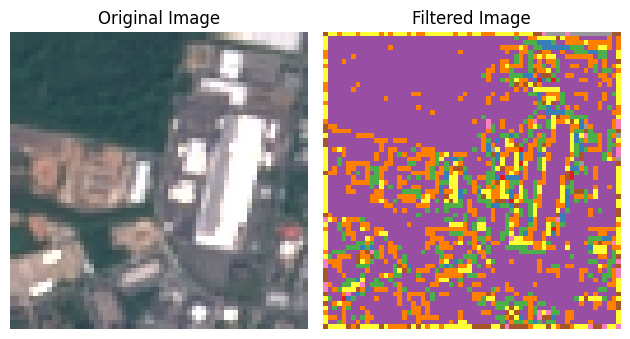

In [13]:
#import matplotlib.pyplot as plt
#from PIL import Image
#import numpy as np

# Load the original image using PIL.Image
image_path = '../../pics/2750/Industrial/Industrial_1.jpg'
original_image = Image.open(image_path)

# Convert the image to a NumPy array
original_image_array = np.array(original_image)

# Flatten the image array
flattened_image = original_image_array.flatten()

# Reshape the flattened image back to the original shape
reshaped_image = flattened_image.reshape(original_image_array.shape)

# Define the subplot layout
fig, axes = plt.subplots(1, 2)

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

# Plot the filtered image
axes[1].imshow(output.squeeze().detach().numpy(), cmap='Set1')
axes[1].set_title('Filtered Image')

# Remove axis ticks
for ax in axes:
    ax.axis('off')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


**Herhaal bovenstaande stappen voor een Forest Image uit de EuroSAT Dataset**

tensor([[[[ 1.3155,  0.7907,  0.7859,  ...,  1.0507,  0.9731,  1.7252],
          [ 0.7972,  0.0053,  0.0062,  ...,  0.0355, -0.0580,  1.0750],
          [ 0.7658, -0.0344,  0.0184,  ...,  0.0727,  0.0203,  1.0793],
          ...,
          [ 0.8478, -0.1255,  0.1209,  ..., -0.0512, -0.0661,  0.7893],
          [ 0.8796, -0.0740,  0.2024,  ..., -0.0999,  0.0336,  0.8667],
          [ 1.6509,  1.0263,  0.7580,  ...,  0.6122,  0.6907,  1.1783]]]])


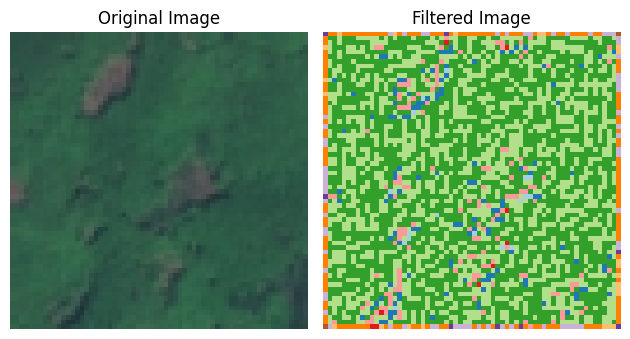

In [14]:
image_path1 = '../../pics/2750/Forest'
forest = io.read_image('../../pics/2750/Forest/Forest_302.jpg')
foresgt = forest.flatten()
forest = forest.float()

image_path1 = '../../pics/2750/Forest/Forest_302.jpg'
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])
image = preprocess(Image.open(image_path1))

# Apply the edgeFilter to the image
output = nn.functional.conv2d(image.unsqueeze(0), edgeFilter, stride=1, padding=1)
print(output)

# Oplossing
image_path1 = '../../pics/2750/Forest/Forest_302.jpg'
original_image = Image.open(image_path1)

# Convert the image to a NumPy array
original_image_array = np.array(original_image)

# Flatten the image array
flattened_image = original_image_array.flatten()

# Reshape the flattened image back to the original shape
reshaped_image = flattened_image.reshape(original_image_array.shape)

# Define the subplot layout
fig, axes = plt.subplots(1, 2)

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

# Plot the filtered image
axes[1].imshow(output.squeeze().detach().numpy(), cmap='Paired')
axes[1].set_title('Filtered Image')

# Remove axis ticks
for ax in axes:
    ax.axis('off')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


### Reflectie

Zijn 'Industrial_1.jpg' en 'Forrest_1.jpg' na een convolutie beter te onderscheiden?

**Extra: varieer de stride en de padding en toon de resultaten**

### Reflectie

Het effect van de convolutie hangt af van verschillende factoren, waaronder de gebruikte kernel en het specifieke doel van de convolutie.

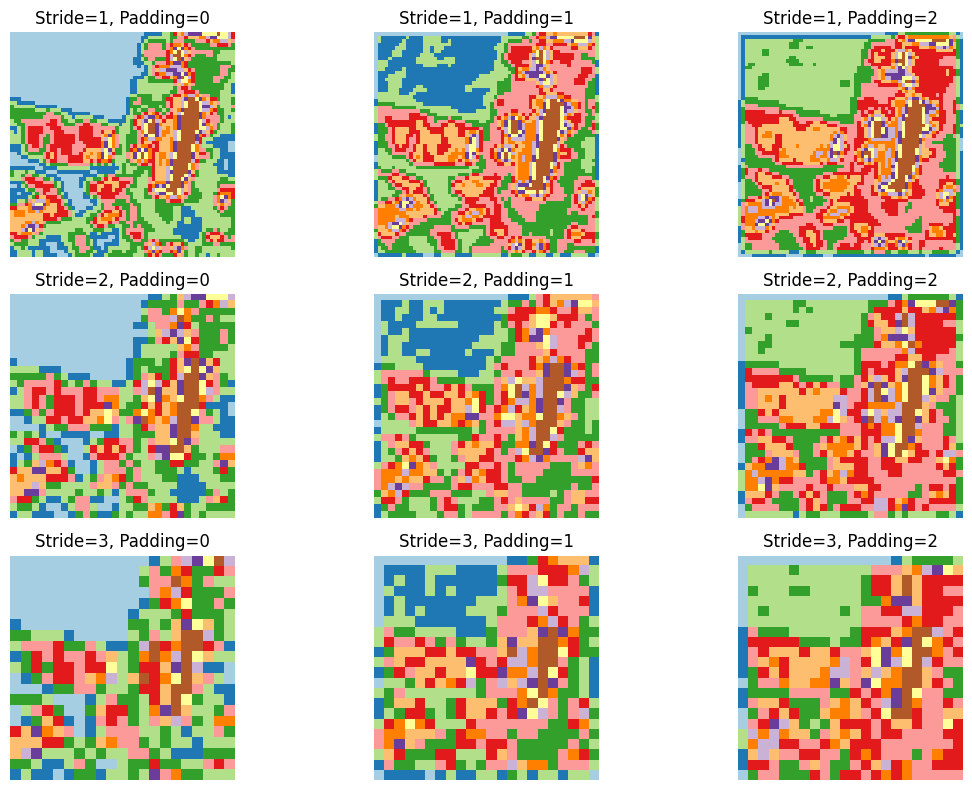

In [15]:


# Load and preprocess the image
image_path = '../../pics/2750/Industrial/Industrial_1.jpg'
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])
image = preprocess(Image.open(image_path))

# Define the square kernel
kernel_size = 3
kernel = torch.ones(kernel_size, kernel_size) / (kernel_size * kernel_size)

# Define the stride and padding values to try
stride_values = [1, 2, 3]
padding_values = [0, 1, 2]

# Create a subplot grid to display the results
num_rows = len(stride_values)
num_cols = len(padding_values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Loop over the stride and padding values
for i, stride in enumerate(stride_values):
    for j, padding in enumerate(padding_values):
        # Apply the convolution with the current stride and padding
        output = F.conv2d(image.unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), stride=stride, padding=padding)

        # Plot the filtered image in the corresponding subplot
        axes[i, j].imshow(output.squeeze().detach().numpy(), cmap='Paired')
        axes[i, j].set_title(f'Stride={stride}, Padding={padding}')
        axes[i, j].axis('off')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)